- practice single sample processing in Seurat
    - copykat + numbat

# 1. Load

In [1]:
library(Seurat)
library(tidyverse)
library(here)
library(glue)

library(DoubletFinder)
library(scDblFinder)

library(SingleR)
library(celldex)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /home/jiehoonk/project/crisprscreen

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required packag

In [119]:
file <- 'S1T_out_filtered_seurat.h5'
counts <- Read10X_h5(here('processed_data/cellbender_out', file))
sample_id <- str_extract(file, "^[^_]+")
obj <- CreateSeuratObject(counts = counts, project = sample_id, min.cells = 0, min.features = 0)
rm(counts)

In [120]:
obj$tissue <- "Tumor"
obj$sample_id <- str_sub(sample_id, 1, 2)
obj$barcodes <- Cells(obj)

# 2. QC & Doublet removal

## 2 - 1. basic QC

In [121]:
obj[["percent.mt"]] <- PercentageFeatureSet(obj, pattern = "^MT-")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


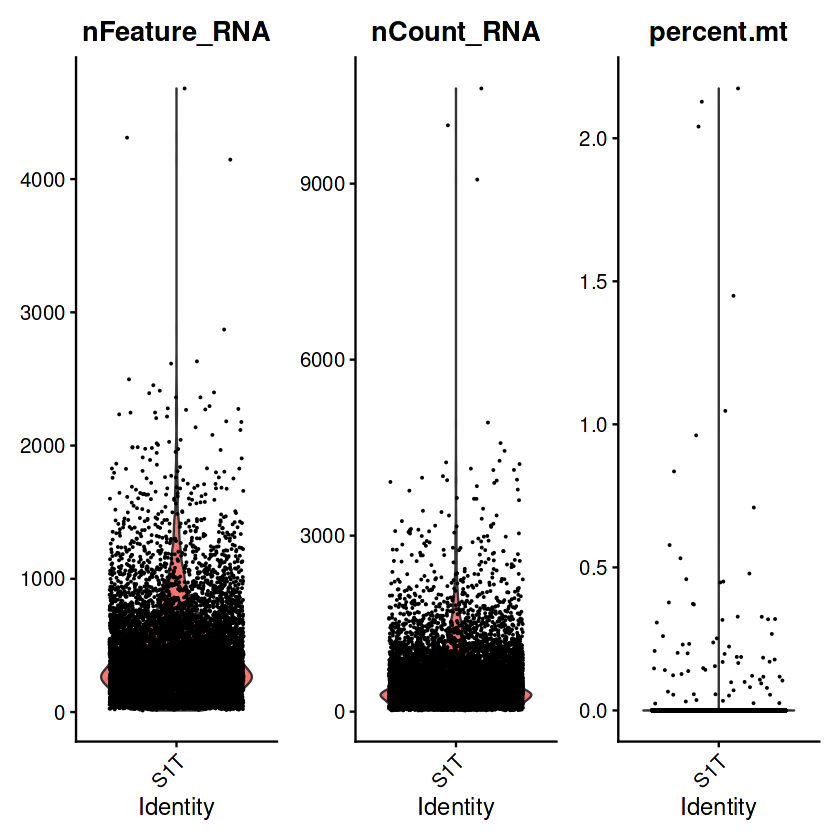

In [122]:
VlnPlot(obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

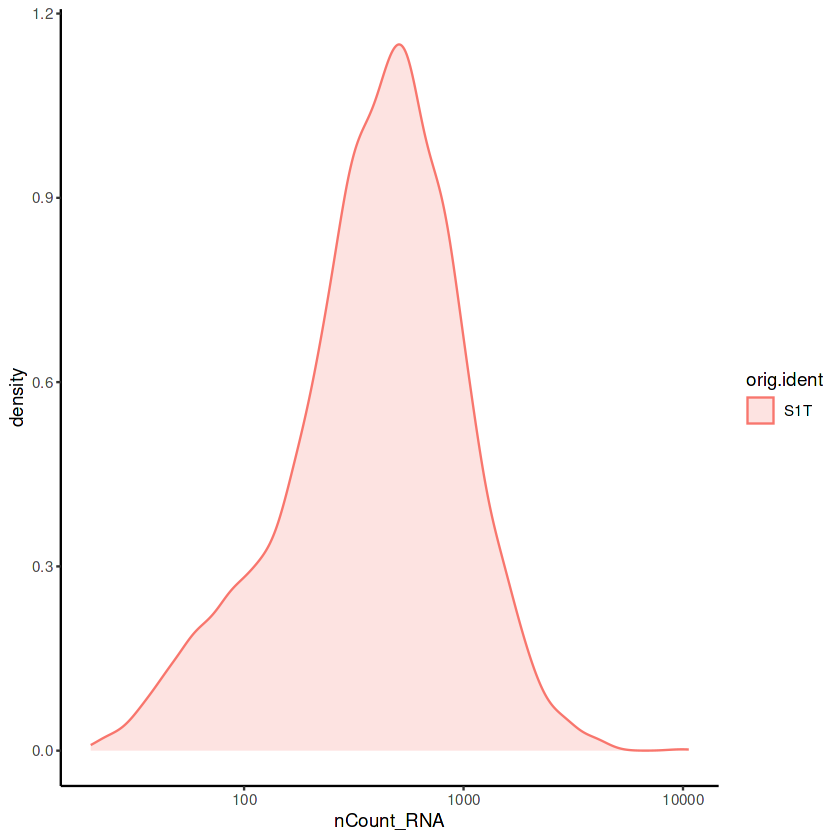

In [123]:
obj[[]]  |> 
    ggplot(aes(color = orig.ident, x=nCount_RNA, fill = orig.ident)) +
    geom_density(alpha = 0.2) + 
    theme_classic() +
    scale_x_log10() 

In [124]:
detect_outliers <- function(data, metric, nmads = 5, bound = "both") {
  values <- data[[metric]]
  med <- median(values)
  mad <- median(abs(values - med))
  
  if (bound == "upper") {
    values > (med + nmads * mad)
  } else if (bound == "both") {
    values < (med - nmads * mad) | values > (med + nmads * mad)
  } else {
    stop("bound must be either 'both' or 'upper'")
  }
}

obj[[]] <- obj[[]] |>
  mutate(
    log1p_nCount_RNA = log1p(nCount_RNA),
    log1p_nFeature_RNA = log1p(nFeature_RNA)
  ) %>%
  mutate(
    outlier = detect_outliers(., "log1p_nCount_RNA", 5) |
             detect_outliers(., "log1p_nFeature_RNA", 5),
    mt_outlier = detect_outliers(., "percent.mt", 3, bound = "upper")
  )

In [132]:
Cells(obj$outlier)
# s2 <- sum(obj$mt_outlier)

NULL

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


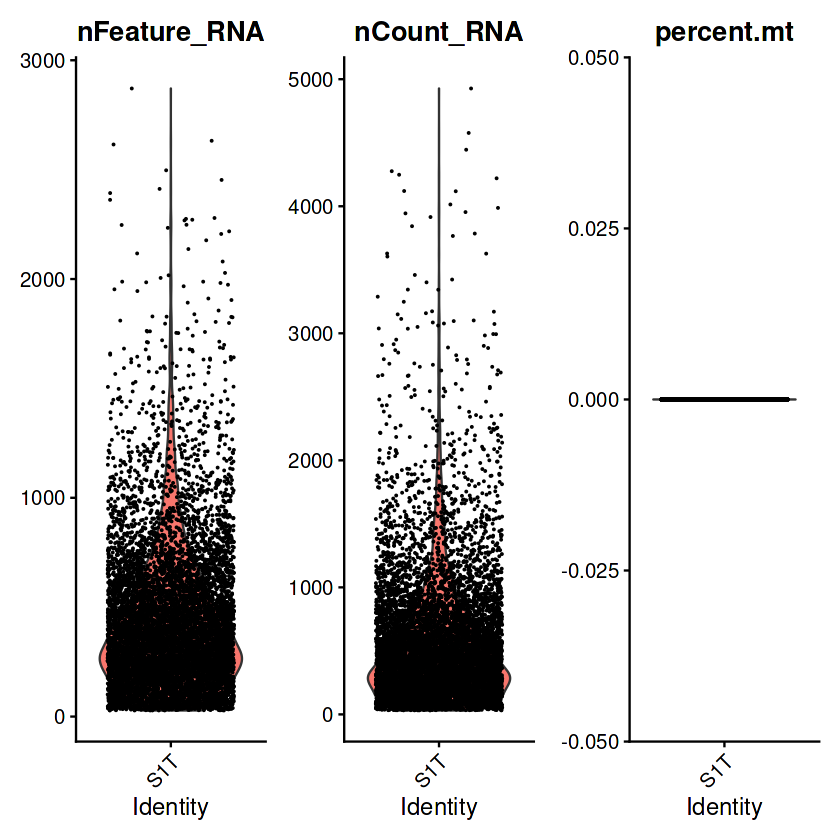

In [95]:
subset(obj, outlier == FALSE & mt_outlier == FALSE) |> 
  VlnPlot(features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [134]:
table(obj$mt_outlier, obj$outlier, useNA = 'ifany')

       
        FALSE TRUE
  FALSE  8791   72
  TRUE     72    0

## 2 - 2. doublet removals : scDblFinder, DoublerFInder

In [135]:
sce <- as.SingleCellExperiment(obj)

Warning message:
“Layer ‘data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”


In [136]:
sce <- scDblFinder(sce)

Warning message in .checkSCE(sce):
“Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out”
Creating ~7148 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 1715 cells excluded from training.

iter=1, 1957 cells excluded from training.

iter=2, 1923 cells excluded from training.

Threshold found:0.498

1103 (12.3%) doublets called



In [137]:
# Extract doublet detection results from SingleCellExperiment object
doublet_metadata <- sce@colData@listData |>
  as.data.frame() |>
  dplyr::select(starts_with('scDblFinder')) |>
  `rownames<-`(sce@colData@rownames)

obj <- AddMetaData(object = obj, metadata = doublet_metadata |> select('scDblFinder.class'))

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


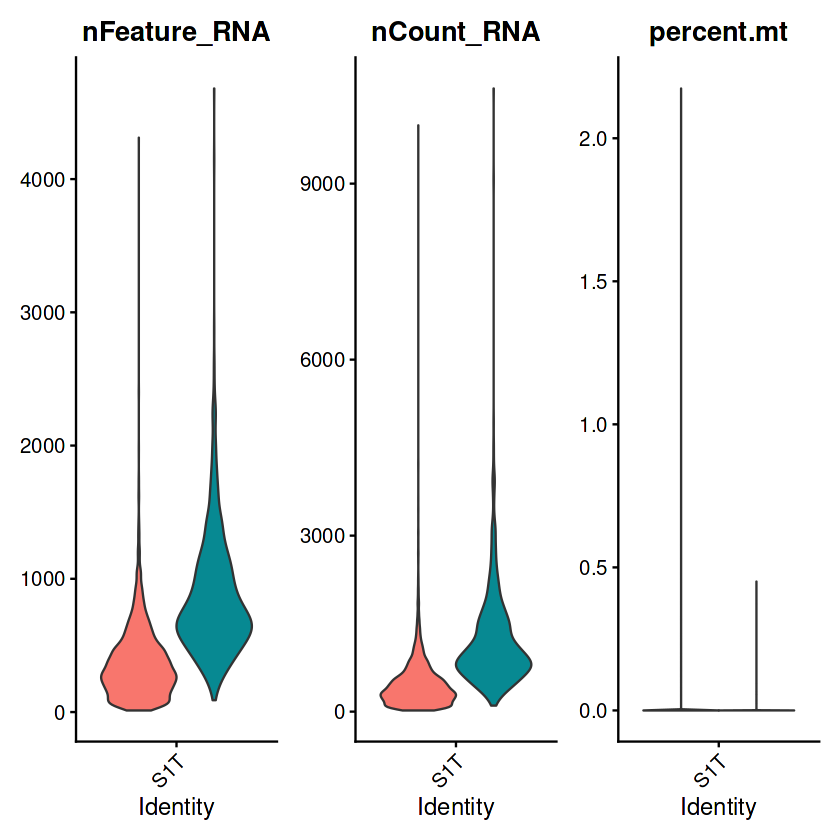

In [138]:
VlnPlot(obj, split.by = 'scDblFinder.class', features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

In [139]:
run_doubletfinder_custom <- function(seurat_obj, multiplet_rate = NULL){
    multiplet_rates_10x <- data.frame('Multiplet_rate'= c(0.004, 0.008, 0.0160, 0.023, 0.031, 0.039, 0.046, 0.054, 0.061, 0.069, 0.076),
                                        'Loaded_cells' = c(800, 1600, 3200, 4800, 6400, 8000, 9600, 11200, 12800, 14400, 16000),
                                        'Recovered_cells' = c(500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000))

    multiplet_rate <- multiplet_rates_10x  |> filter(Recovered_cells < nrow(seurat_obj@meta.data)) %>% 
        dplyr::slice(which.max(Recovered_cells)) %>% 
        select(Multiplet_rate) %>% as.numeric(as.character()) 

  sample <- NormalizeData(seurat_obj)
  sample <- FindVariableFeatures(sample)
  sample <- ScaleData(sample)
  sample <- RunPCA(sample, nfeatures.print = 10)
  
  stdv <- sample[["pca"]]@stdev
  percent_stdv <- (stdv/sum(stdv)) * 100
  cumulative <- cumsum(percent_stdv)
  co1 <- which(cumulative > 90 & percent_stdv < 5)[1] 
  co2 <- sort(which((percent_stdv[1:length(percent_stdv) - 1] - 
                       percent_stdv[2:length(percent_stdv)]) > 0.1), 
              decreasing = T)[1] + 1
  min_pc <- min(co1, co2)
  
  sample <- RunUMAP(sample, dims = 1:min_pc)
  sample <- FindNeighbors(object = sample, dims = 1:min_pc)              
  sample <- FindClusters(object = sample, resolution = 0.1)
  
  sweep_list <- paramSweep(sample, PCs = 1:min_pc, sct = FALSE)   
  sweep_stats <- summarizeSweep(sweep_list)
  bcmvn <- find.pK(sweep_stats) 
  optimal.pk <- bcmvn %>% 
    filter(BCmetric == max(BCmetric)) %>%
    select(pK)
  optimal.pk <- as.numeric(as.character(optimal.pk[[1]]))
  
  annotations <- sample@meta.data$seurat_clusters 
  homotypic.prop <- modelHomotypic(annotations) 
  
  nExp.poi <- round(multiplet_rate * nrow(sample@meta.data)) 
  nExp.poi.adj <- round(nExp.poi * (1 - homotypic.prop)) 
  
  sample <- doubletFinder(seu = sample, PCs = 1:min_pc, pK = optimal.pk, nExp = nExp.poi.adj) 
  colnames(sample@meta.data)[grepl('DF.classifications.*', colnames(sample@meta.data))] <- "doublet_finder"
  
  double_finder_res <- sample@meta.data['doublet_finder'] 
  return(double_finder_res)
}

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  PTPRZ1, SNTG1, GLIS3, NRCAM, FMN2, DLGAP1, RYR3, OXR1, SOX5, LHFPL3 
Negative:  IL1RAPL1, ST18, NKAIN2, ELMO1, CNTNAP4, SPOCK3, DLC1, DOCK5, PCSK6, EDIL3 
PC_ 2 
Positive:  LRMDA, MSR1, DOCK8, APBB1IP, CTSB, ENSG00000249001, LNCAROD, SYK, ARHGAP15, SLC11A1 
Negative:  IL1RAPL1, CADM2, TMTC2, SLC24A2, NKAIN2, DLC1, SLC44A1, PLCL1, ST18, NCKAP5 
PC_ 3 
Positive:  CSMD1, KMT2E-AS1, ENSG00000273338, HSPA1A, NRN1, CHRM3, AKAP12, HILPDA, UBC, PTPRZ1 
Negative:  LRMDA, PLXDC2, MSR1, DOCK8, SPP1, CTSB, FMN1, SAT1, APBB1IP, TPRG1 
PC_ 4 
Positive:  AKAP12, NALF1, RASGEF1B, NRG3, DELEC1, ENSG00000286533, RNF19A, PRKG1, CHI3L1, TNC 
Negative:  LHFPL3, PTPRZ1, SNTG1, ENSG00000271860, ENSG00000233420, BRINP3, ADAMTS6, NXPH1, TENM1, LUZP2 
PC_ 5 
Positive:  ABCA13, WWC1, NALF1, CATSPERB, ENSG00000229588, KCNN3, PRKG1, LTF, NRG3, RASGEF1B 
Negative:  CHRM3, ADGRL2, PDE4D, DNAH11

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8935
Number of edges: 280803

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9483
Number of communities: 6
Elapsed time: 0 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 2978 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


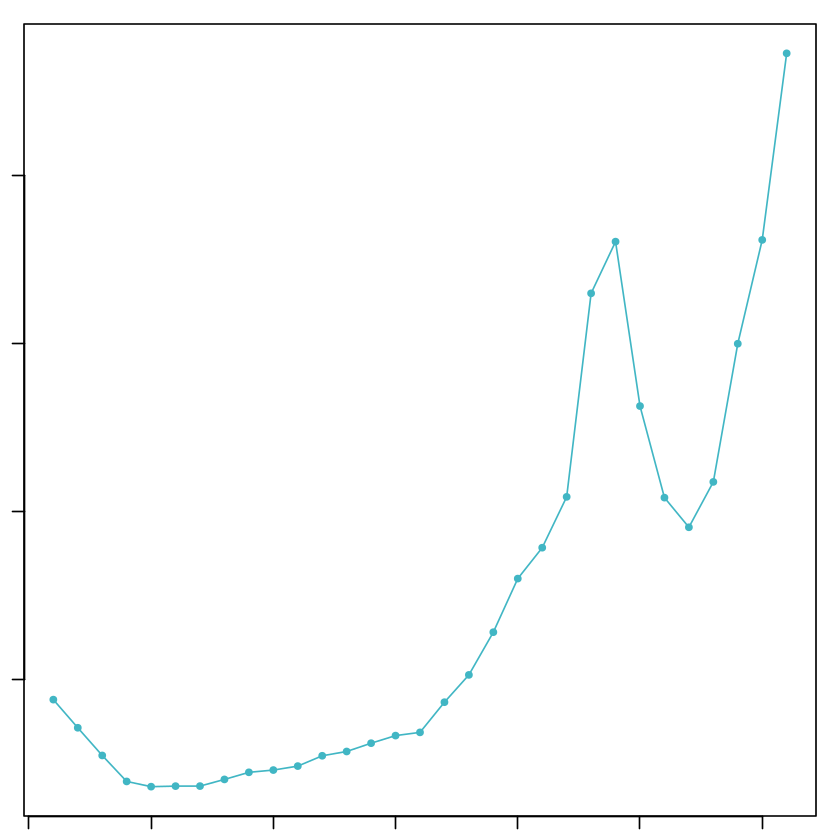

In [140]:
doublet_metadata <- run_doubletfinder_custom(obj)

In [141]:
obj <- AddMetaData(obj, doublet_metadata, col.name = "doublet_finder")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


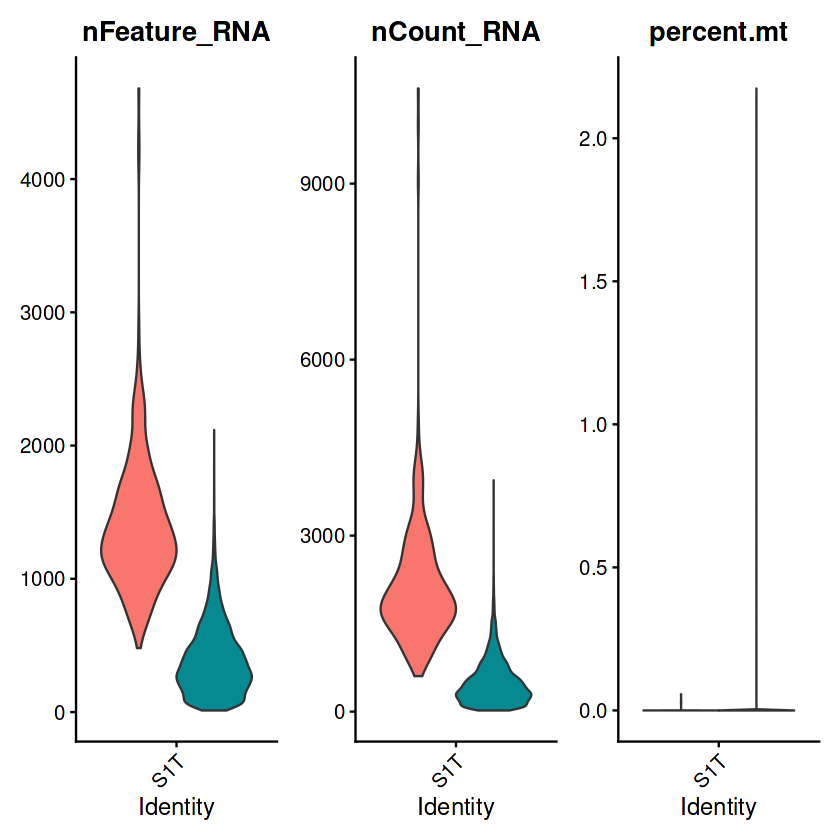

In [142]:
VlnPlot(obj, split.by = 'doublet_finder', features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

In [143]:
table('scDblFinder' = obj$scDblFinder.class, 'DoubletFinder' = obj$doublet_finder)

           DoubletFinder
scDblFinder Doublet Singlet
    singlet      81    7751
    doublet     242     861

In [144]:
obj <- subset(obj, doublet_finder == "Singlet" | scDblFinder.class == "Singlet")

In [145]:
obj

An object of class Seurat 
38606 features across 8612 samples within 1 assay 
Active assay: RNA (38606 features, 0 variable features)
 1 layer present: counts

# 3. Normalization

In [146]:
obj <- SCTransform(obj, verbose = FALSE)

In [148]:
obj <- RunPCA(obj, verbose = FALSE, assay = "SCT")

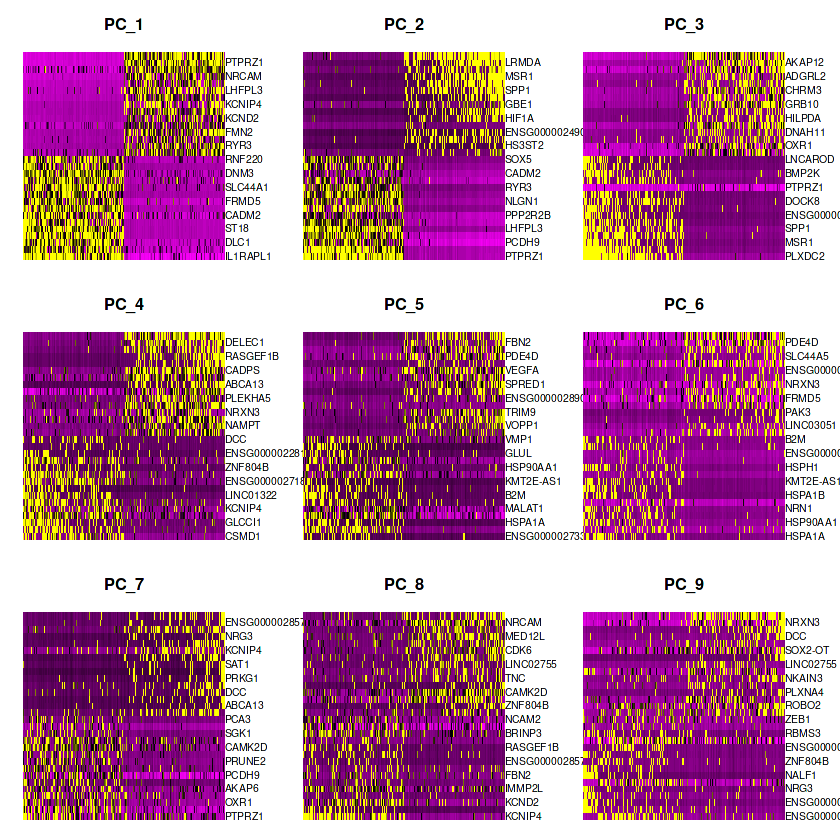

In [151]:
DimHeatmap(obj, dims = 1:9, cells = 500, balanced = TRUE, ncol = 3)

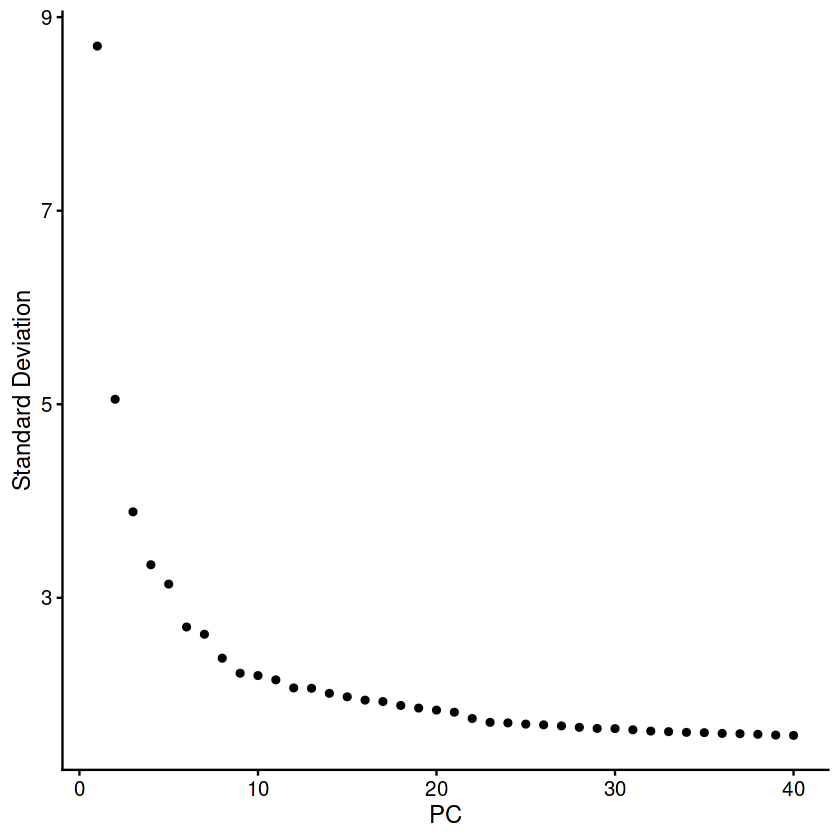

In [152]:
ElbowPlot(obj, ndims = 40)

In [155]:
obj <- FindNeighbors(obj, dims = 1:30)

Computing nearest neighbor graph



Computing SNN



In [176]:
obj <- FindClusters(obj, algorithm = 4, resolution = 1.0)

Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by c

In [177]:
obj <- RunUMAP(obj, dims = 1:30)

20:09:59 UMAP embedding parameters a = 0.9922 b = 1.112

20:09:59 Read 8612 rows and found 30 numeric columns

20:09:59 Using Annoy for neighbor search, n_neighbors = 30

20:09:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:10:00 Writing NN index file to temp file /tmp/RtmpEEybuZ/file24e8d341c7475

20:10:00 Searching Annoy index using 1 thread, search_k = 3000

20:10:02 Annoy recall = 100%

20:10:04 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:10:06 Initializing from normalized Laplacian + noise (using RSpectra)

20:10:06 Commencing optimization for 500 epochs, with 371106 positive edges

20:10:15 Optimization finished



In [180]:
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,tissue,sample_id,barcodes,percent.mt,log1p_nCount_RNA,log1p_nFeature_RNA,outlier,mt_outlier,scDblFinder.class,doublet_finder,nCount_SCT,nFeature_SCT,SCT_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<fct>,<chr>,<dbl>,<int>,<fct>,<fct>
ACATTTCAGGTGAGAA-1,S1T,3944,2117,Tumor,S1,ACATTTCAGGTGAGAA-1,0,8.280204,7.658228,FALSE,FALSE,doublet,Singlet,603,487,1,1
GAACGTTGTTCATCTT-1,S1T,3113,1807,Tumor,S1,GAACGTTGTTCATCTT-1,0,8.043663,7.499977,FALSE,FALSE,doublet,Singlet,596,483,7,7
GATCAGTTCCCTTGGT-1,S1T,2901,1660,Tumor,S1,GATCAGTTCCCTTGGT-1,0,7.973155,7.415175,FALSE,FALSE,singlet,Singlet,603,467,1,1
ATGCCTCTCGTTAGAC-1,S1T,2796,1712,Tumor,S1,ATGCCTCTCGTTAGAC-1,0,7.936303,7.446001,FALSE,FALSE,singlet,Singlet,538,425,2,2
CCTCAGTGTACGATTC-1,S1T,2676,1603,Tumor,S1,CCTCAGTGTACGATTC-1,0,7.892452,7.380256,FALSE,FALSE,singlet,Singlet,552,419,1,1
CTATCCGGTAGAGATT-1,S1T,2565,1593,Tumor,S1,CTATCCGGTAGAGATT-1,0,7.850104,7.374002,FALSE,FALSE,singlet,Singlet,521,401,7,7


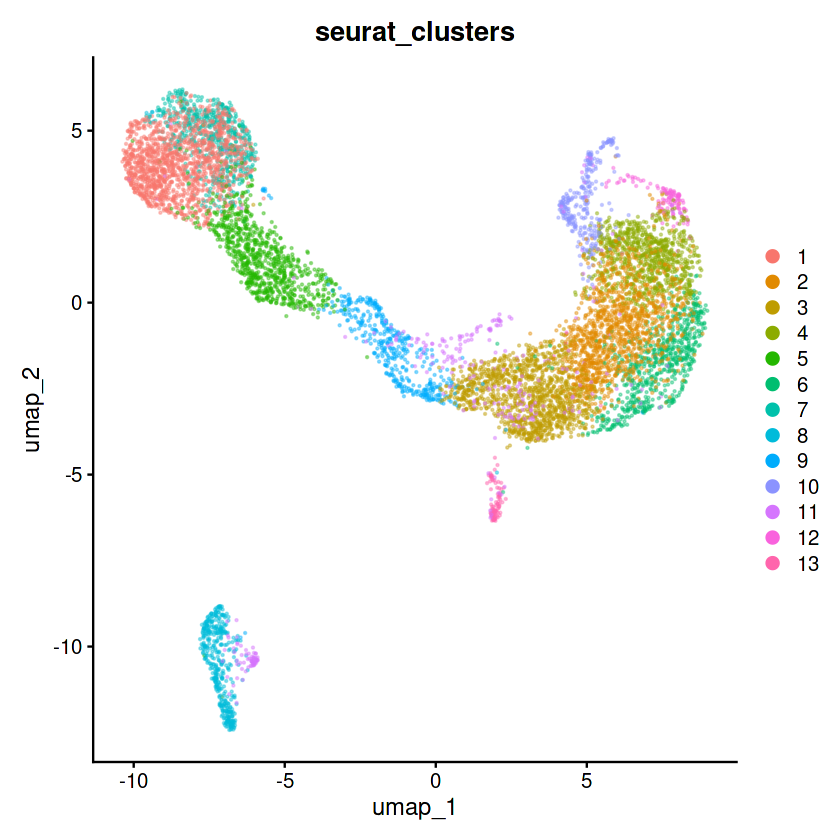

In [184]:
DimPlot(obj, reduction = "umap", group.by = "seurat_clusters", alpha=0.4)

# 4. Annotation

In [186]:
markers <- FindAllMarkers(obj, only.pos = TRUE)

Calculating cluster 1



Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [188]:
markers |> 
    arrange(cluster, desc(avg_log2FC), desc(p_val_adj))  |> 
    group_by(cluster) |>
    slice_max(n = 5, order_by = avg_log2FC)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.474156e-13,4.270633,0.010,0.000,3.028359e-09,1,RNASE1
1.588611e-23,4.270633,0.019,0.001,3.263484e-19,1,ENSG00000289061
1.768486e-302,3.752785,0.308,0.027,3.633001e-298,1,CNDP1
4.589719e-22,3.617499,0.021,0.002,9.428660e-18,1,ENSG00000264340
1.332844e-14,3.565376,0.014,0.001,2.738062e-10,1,LINC00870
4.038037e-12,2.734677,0.017,0.002,8.295339e-08,2,SHH
6.109714e-06,2.390029,0.011,0.003,1.255119e-01,2,LINC01993
4.182178e-06,2.261924,0.010,0.002,8.591449e-02,2,FABP9
2.259343e-06,2.252526,0.012,0.003,4.641368e-02,2,KIF18B


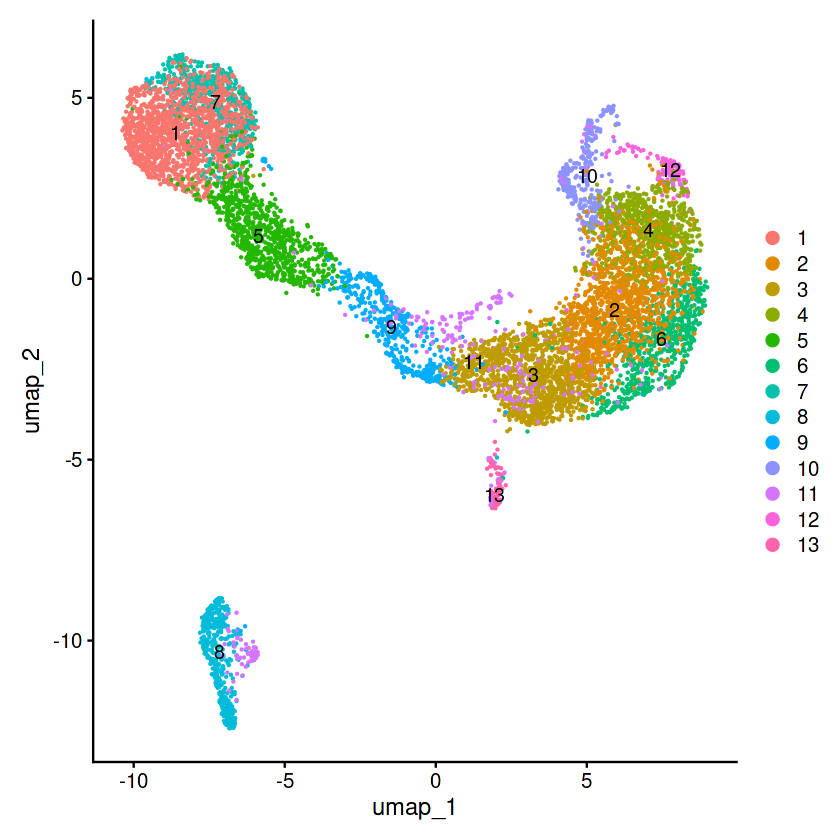

In [193]:
DimPlot(obj, label = TRUE)

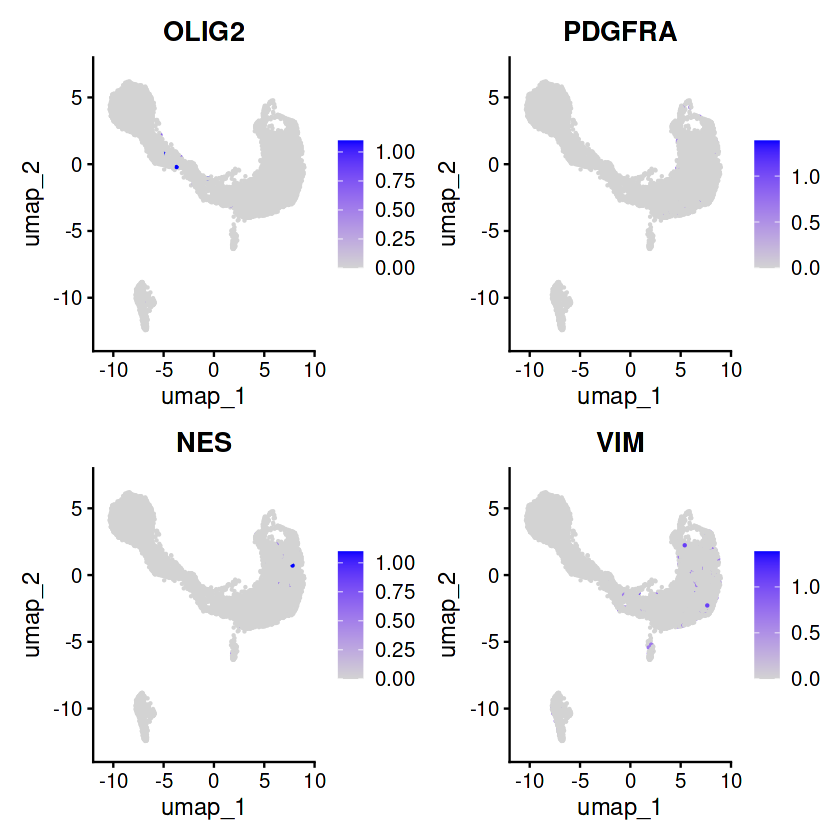

In [191]:
FeaturePlot(obj, features = c("OLIG2", "PDGFRA", "NES", "VIM"))

In [201]:
ref <- HumanPrimaryCellAtlasData()

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache



In [202]:
annot <- SingleR(test = obj, ref = ref, labels = ref$label.main)

Warning message:
“The following arguments are not used: drop”


In [ ]:
head(annot)